Playing around with some stuff

In [5]:
import obspy
import numpy as np
from obspy.clients.fdsn.client import Client
#import cartopy TODO Can't install cartopy on Noah's local machine
import pandas as pd
import geopandas as gpd
from collections import defaultdict
import matplotlib.pyplot as plt

In [6]:
# Make an obspy Catalog object from the QuakeML file.
cat = obspy.core.event.read_events('XO_2019_01.quakeml')
#Copied from Maleen's code
#Should take about 1 minute to run on Noah's laptop, be patient

In [17]:
def quakeMLReader(event):
    epicenter = (event.origins[0].latitude, event.origins[0].longitude) #stores event epicenter lat/lon as tuple
    magnitude = event.magnitudes[0].mag #stores event magnitude
    birthday = event.origins[0].time #stores time at which event occurs
    results = []
    for arrival in event.origins[0].arrivals: #goes through arrival data and notes phase, azimuthal angle, distance from epicenter and pick_id in 2D list
        phase = arrival.phase
        azi = arrival.azimuth
        dist = arrival.distance * 111 #there is a note in Maleen's code about this being in degrees
        pick_id = arrival.pick_id
        result = [phase, azi, dist, pick_id]
        results.append(result)
    arrivals = pd.DataFrame(results)
    arrivals.columns = ['phase','azimuth','distance','pick_id'] #makes DataFrame of arrivals data
    results = []
    for pick in event.picks: #goes through pick data and notes time of arrival, station data and pick_id in 2D list
        pick_id = pick.resource_id
        time = pick.time
        network_code = pick.waveform_id.network_code
        station_code = pick.waveform_id.station_code
        result = [pick_id, time, network_code, station_code]
        results.append(result)
    picks = pd.DataFrame(results)
    picks.columns = ['pick_id','time','network_code','station_code'] #makes DataFrame of picks data
    picks['travel_time'] = picks['time'] - birthday
    log = arrivals.merge(picks, left_on='pick_id', right_on='pick_id').sort_values(by='travel_time') #merges arrivals and picks data
    bonus = (epicenter, magnitude, birthday)
    return log, bonus
#goal to make a robust function that is given a quakeML filepath and creates a pandas DataFrame with helpful parameters

In [18]:
log, bonus = quakeMLReader(cat[7])
log

,phase,azimuth,distance,pick_id,time,network_code,station_code,travel_time
120,P,194.20,53.946,quakeml:earthquake.alaska.edu/pick/1263,2019-01-02T06:48:54.890000Z,XO,KD05,11.167
121,P,56.89,54.612,quakeml:earthquake.alaska.edu/pick/1264,2019-01-02T06:48:55.078000Z,AV,Q20K,11.355
122,P,149.69,61.827,quakeml:earthquake.alaska.edu/pick/1265,2019-01-02T06:48:55.960000Z,XO,KD02,12.237
123,P,337.99,70.152,quakeml:earthquake.alaska.edu/pick/1266,2019-01-02T06:48:56.699000Z,AK,Q19K,12.976
124,P,150.14,71.595,quakeml:earthquake.alaska.edu/pick/1267,2019-01-02T06:48:56.768000Z,II,KDAK,13.045
...,...,...,...,...,...,...,...,...
114,P,3.00,1088.910,quakeml:earthquake.alaska.edu/pick/1686,2019-01-02T06:51:00.811000Z,AK,E22K,137.088
115,P,82.37,1092.795,quakeml:earthquake.alaska.edu/pick/1687,2019-01-02T06:51:01.197000Z,AK,JIS,137.474
116,P,87.11,1098.234,quakeml:earthquake.alaska.edu/pick/1688,2019-01-02T06:51:01.451000Z,AK,S32K,137.728
117,P,10.19,1104.672,quakeml:earthquake.alaska.edu/pick/1689,2019-01-02T06:51:01.894000Z,AK,E24K,138.171


P-wave slope is 8.167426703737915 km/s.
S-wave slope is 4.825493373364722 km/s.


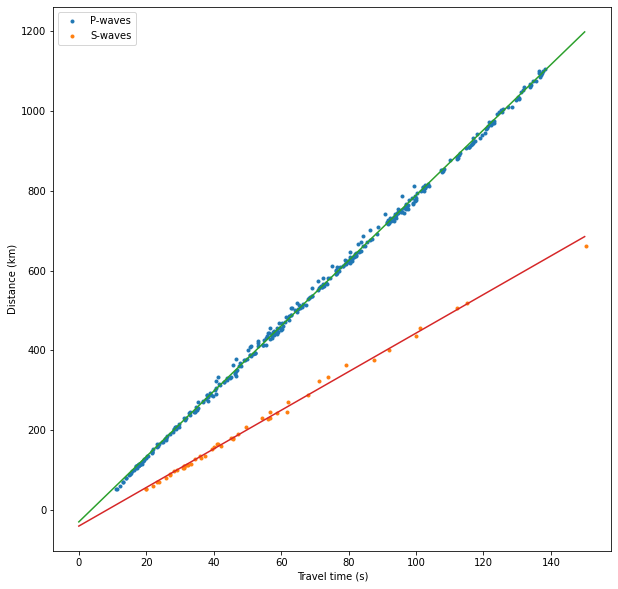

In [ ]:
#replicating Maleen's plot, some cod is copied and modified
p_log = log[log['phase'] == 'P']
s_log = log[log['phase'] == 'S']

fig,ax = plt.subplots(1,1,figsize=[10,10])
ax.plot(p_log['travel_time'],p_log['distance'],'.')
ax.plot(s_log['travel_time'],s_log['distance'],'.')
ax.set_xlabel('Travel time (s)')
ax.set_ylabel('Distance (km)')
ax.legend(['P-waves','S-waves'])

# P-wave fit
m,b = np.polyfit(p_log['travel_time'].tolist(),p_log['distance'].tolist(),1)
x_p = np.linspace(0,150)
ax.plot(x_p,x_p*m + b,'-')
print('P-wave slope is '+str(m)+' km/s.')

# S-wave fit
m,b = np.polyfit(s_log['travel_time'].tolist(),s_log['distance'].tolist(),1)
x_p = np.linspace(0,150)
ax.plot(x_p,x_p*m + b,'-')
print('S-wave slope is '+str(m)+' km/s.')

TODO: Feedback from Maleen 16 AUG 2200 PDT

Great start! Now what you now need is the

location of all these individual stations -> try plotting stations
Look up how the speed varies with azimuth
Then work on how to make interactive plots of travel time
Work on how to make GIFs of travel time passing (some sort of a moving contour maybe... be creative)
Perhaps interpolate to get travel times for any point
Try exploring whether velocity varies with different earthquakes events
try to plot how the seismic waveform looks like for stations with P and S wave times
plot different events on the catalog
I guess part of this is to do your own exploration, of dataset, see whether there are interesting things

For science portion,

Think what causes velocity variations on earth, try to come up with a interpretation, there are many things other than magma that slows down waves, and also sometimes they speed up
Think about implications of being able to determine the wave-speed of an earthquake
Think about how fast these are compared to a tsunami wave propergating through water from the origin (more reading)

TODO: In order to plot earthquake arrivals on a map, need lat/lon points of each station.  Can do this either by creating a dict-like object with station codes and locations (and then integrate into quakeML reader), or by projecting the station using range/bearing (distance, azimuth) from the epicenter.

TODO: Make plot to show the azimuthal dependence of wave velocity.  A compass rose could be a good tool here.

----- Random Experimentation Below, no reason to read past this point -----

In [1]:
cat[7].origins[0].time

cat: [7].origins[0].time: No such file or directory


In [39]:
type(len(cat[7].picks))

int

In [46]:
resource_ids = []
magnitudes = []
pick_counts =[]
for event in cat:
    resource_ids.append(event.resource_id)
    magnitudes.append(event.magnitudes[0].mag)
    pick_counts.append(len(event.picks))
summary = pd.DataFrame(resource_ids, magnitudes).reset_index()
summary.columns = ['magnitudes','resource_ids']
summary['pick_counts'] = pick_counts
#summary.sort_values(by='magnitudes', ascending=False)
summary

,magnitudes,resource_ids,pick_counts
0,2.4,quakeml:earthquake.alaska.edu/event/0191qjphy,35
1,2.9,quakeml:earthquake.alaska.edu/event/0191r79en,66
2,3.0,quakeml:earthquake.alaska.edu/event/0191r7uq7,161
3,3.5,quakeml:earthquake.alaska.edu/event/0191u5who,162
4,3.5,quakeml:earthquake.alaska.edu/event/0191uwq6k,91
...,...,...,...
392,3.2,quakeml:earthquake.alaska.edu/event/019140h1u5,52
393,1.0,quakeml:earthquake.alaska.edu/event/0191dnhpwp,12
394,1.7,quakeml:earthquake.alaska.edu/event/0191dp5tvd,27
395,2.6,quakeml:earthquake.alaska.edu/event/0191dvyc5x,35


In [55]:
cat[7].picks[2]

Pick
	     resource_id: ResourceIdentifier(id="quakeml:earthquake.alaska.edu/pick/1574")
	            time: UTCDateTime(2019, 1, 2, 6, 50, 17, 575000)
	     waveform_id: WaveformStreamID(network_code='TA', station_code='I17K', channel_code='BHZ', location_code='--')
	 evaluation_mode: 'automatic'
	   creation_info: CreationInfo(agency_id='AK', author='Alaska Earthquake Center, UAF/GI', creation_time=UTCDateTime(2019, 1, 2, 6, 51, 5, 319000))